In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy import signal
from scipy.integrate import simps
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import learning_curve, ShuffleSplit, cross_val_score, train_test_split, StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler

from mne import Epochs, pick_types, events_from_annotations, EpochsArray, create_info
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP
from mne.time_frequency import psd_array_welch, psd_array_multitaper, stft
import seaborn as sns
from tqdm import tqdm

In [2]:
# keras/tensorflow

import sys
import tensorflow.keras as keras
import pandas as pd
import sklearn as sk
import tensorflow as tf
import platform

from keras.models import Sequential
from keras.layers import Dense, LSTM, BatchNormalization, Dropout
from keras.regularizers import l2
import keras_tuner as kt
from keras.optimizers import Adam

import nengo
from nengo.utils.filter_design import cont2discrete
import nengo_dl

from keras_lmu import LMU
import keras_spiking


print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Python Platform: macOS-13.3.1-arm64-arm-64bit
Tensor Flow Version: 2.9.0
Keras Version: 2.9.0

Python 3.9.15 | packaged by conda-forge | (main, Nov 22 2022, 08:48:25) 
[Clang 14.0.6 ]
Pandas 1.5.2
Scikit-Learn 1.2.0
GPU is available


In [3]:
# load batch_stft.npy and train_idx.npy
# reconstructed_stft = np.load('preprocessed_data/reconstructed_stft.npy')
source_stft = np.load('preprocessed_data/source_stft.npy')
test_idx = np.load('preprocessed_data/test_idx.npy')
train_idx = np.load('preprocessed_data/train_idx.npy')
labels = np.load('preprocessed_data/labels.npy')
freqs = np.load('preprocessed_data/freq.npy')

train_stft = source_stft[train_idx]
test_stft = source_stft[test_idx]
welch_test = np.mean(test_stft, axis=3)
welch_train = np.mean(train_stft, axis=3)
y_train = labels[train_idx]
y_test = labels[test_idx]

# initialize sequential data
scaler = StandardScaler()

# log psd features in sensorimotor range
X_train = train_stft[:, :, np.logical_and(freqs >= 8, freqs <= 30), :]
print(X_train.shape)

# merge channel and fft axis (1, 2)
# move time axis to position 1 from 2 (keras format)
X_train = np.moveaxis(X_train.reshape(X_train.shape[0], -1, X_train.shape[-1]), 2, 1)
X_train = scaler.fit_transform(X_train.reshape((X_train.shape[0]*X_train.shape[1],X_train.shape[2]))).reshape((X_train.shape[0],X_train.shape[1],X_train.shape[2]))
print(X_train.shape)


X_test = test_stft[:, :, np.logical_and(freqs >= 8, freqs <= 30), :]
print(X_test.shape)
X_test = np.moveaxis(X_test.reshape(X_test.shape[0], -1, X_test.shape[-1]), 2, 1)
X_test = scaler.transform(X_test.reshape((X_test.shape[0]*X_test.shape[1],X_test.shape[2]))).reshape((X_test.shape[0],X_test.shape[1],X_test.shape[2]))
print(X_test.shape)



(3725, 4, 23, 9)
(3725, 9, 92)
(466, 4, 23, 9)
(466, 9, 92)


In [4]:
# export standard scaler using pkl 
import pickle
with open('preprocessed_data/scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)



# Vanilla LMU Eval

In [24]:
keras_lmu = keras.models.load_model('models/keras-lmu')



Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [25]:
lmu_eval = keras_lmu.evaluate(X_test, y_test)


2023-05-11 12:55:06.233472: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


15/15 [==============================] - 1s 28ms/step - loss: 0.3971 - accuracy: 0.9356


In [26]:
# evaluate the model on the test set
y_pred = keras_lmu.predict(X_test)
y_pred = (y_pred>0.5).astype(int)
print(classification_report(y_test, y_pred))

15/15 [==============================] - 0s 21ms/step
              precision    recall  f1-score   support

           0       0.94      0.93      0.94       233
           1       0.93      0.94      0.94       233

    accuracy                           0.94       466
   macro avg       0.94      0.94      0.94       466
weighted avg       0.94      0.94      0.94       466



In [10]:
@keras_spiking.ModelEnergy.register_layer(LMU)
def LMU_stats(node):
    input_d = 92
    units = 64
    order = 32

    # Connections: three sets of connections (x->h, m->h, h->h)
    connections_x_to_h = input_d * units
    connections_m_to_h = order * units
    connections_h_to_h = units * units
    connections = connections_x_to_h + connections_m_to_h + connections_h_to_h

    # Neurons: number of neurons in the LMU is equal to the number of units
    neurons = units

    return {"connections": connections, "neurons": neurons, "spiking": True}

energy = keras_spiking.ModelEnergy(keras_lmu, example_data=X_test)
energy.summary(
     columns=(
        "name",
        "params",
        "energy cpu",
        "energy loihi",
        "energy gpu",
        "synop_energy cpu",
        "synop_energy gpu",
        "neuron_energy cpu",
        "neuron_energy gpu",
    ),
    timesteps_per_inference=9,
    dt=0.001,
    print_warnings=False)

15/15 [==============================] - 0s 22ms/step
Layer (typ|Param #|J/inf (cpu|J/inf (loi|J/inf (gpu|Synop J/inf|Synop J/in|Neuron J/in|Neuron J/in
----------|-------|----------|----------|----------|-----------|----------|-----------|-----------
lmu_14 (LM|  12720|    0.0001|   4.9e-08|   3.6e-06|     0.0001|   3.6e-06|    5.5e-07|    1.9e-08
dense_14 (|     65|   5.6e-07|   7.4e-10|   1.9e-08|    5.5e-07|   1.9e-08|    8.6e-09|      3e-10
Total energy per inference [Joules/inf] (cpu): 1.05e-04
Total energy per inference [Joules/inf] (loihi): 4.98e-08
Total energy per inference [Joules/inf] (gpu): 3.65e-06


# Vanilla LSTM Eval

In [11]:
lstm = keras.models.load_model('models/lstm_model')

In [12]:
lstm_eval = lstm.evaluate(X_test, y_test)

15/15 [==============================] - 1s 12ms/step - loss: 0.3076 - accuracy: 0.9356


In [13]:
# evaluate the model on the test set
y_pred = lstm.predict(X_test)
y_pred = (y_pred>0.5).astype(int)
print(classification_report(y_test, y_pred))

15/15 [==============================] - 0s 9ms/step
              precision    recall  f1-score   support

           0       0.93      0.94      0.94       233
           1       0.94      0.93      0.94       233

    accuracy                           0.94       466
   macro avg       0.94      0.94      0.94       466
weighted avg       0.94      0.94      0.94       466



In [14]:
@keras_spiking.ModelEnergy.register_layer(LSTM)
def LSTM_stats(node):
    input_d = 92
    units = 64

    # Connections: 2 sets, input->hidden and hidden->hidden for 4 gates
    connections_input_to_cell = 4 * input_d * units
    connections_cell_to_cell = 4 * units * units
    connections = connections_input_to_cell + connections_cell_to_cell

    # Neurons: number of neurons in the LSTM is equal to the number of units
    neurons = units

    return {"connections": connections, "neurons": neurons, "spiking": True}

energy = keras_spiking.ModelEnergy(lstm, example_data=X_test)
energy.summary(
     columns=(
        "name",
        "params",
        "energy cpu",
        # "energy loihi",
        "energy gpu",
        "synop_energy cpu",
        "synop_energy gpu",
        "neuron_energy cpu",
        "neuron_energy gpu",
    ),
    timesteps_per_inference=9,
    dt=0.001,
    print_warnings=False)

/Users/anushmutyala/Documents/GitHub/Energy-Efficient-Decoding-of-EEG-Motor-Imagery-using-Spiking-Legendre-Memory-Units/keras-spiking/keras_spiking/model_energy.py:793: UserWarning: Cannot compute stats for layer of type 'BatchNormalization'.Use `ModelEnergy.register_layer` to register this layer.
  warnings.warn(


15/15 [==============================] - 0s 6ms/step
Layer (type)      |Param #|J/inf (cpu)|J/inf (gpu)|Synop J/inf|Synop J/inf|Neuron J/in|Neuron J/in
------------------|-------|-----------|-----------|-----------|-----------|-----------|-----------
lstm (LSTM)       |  40192|    0.00034|    1.2e-05|    0.00034|    1.2e-05|    5.5e-07|    1.9e-08
batch_normalizatio|    256|          0|          0|          0|          0|          0|          0
dense_9 (Dense)   |     65|    5.6e-07|    1.9e-08|    5.5e-07|    1.9e-08|    8.6e-09|      3e-10
Total energy per inference [Joules/inf] (cpu): 3.45e-04
Total energy per inference [Joules/inf] (gpu): 1.20e-05


# Spiking LMU Eval

In [4]:
# reshape labels to rank 3 as expected in Nengo)
y_train_3 = y_train.reshape((y_train.shape[0], 1, 1))
y_test_3 = y_test.reshape((y_test.shape[0], 1, 1))

print(X_test.shape, y_test_3.shape)

(466, 9, 92) (466, 1, 1)


In [16]:
class SpikingLMUCell(nengo.Network):
    def __init__(self, units, order, theta, input_d, **kwargs):
        super().__init__(**kwargs)

        # compute the A and B matrices according to the LMU's mathematical derivation
        # (see the paper for details)
        Q = np.arange(order, dtype=np.float64)
        R = (2 * Q + 1)[:, None] / theta
        j, i = np.meshgrid(Q, Q)

        A = np.where(i < j, -1, (-1.0) ** (i - j + 1)) * R
        B = (-1.0) ** Q[:, None] * R
        C = np.ones((1, order))
        D = np.zeros((1,))
        
#          here we are using zero-order hold(zoh) method to 
#        discretize the value of A and B 
        A, B, _, _, _ = cont2discrete((A, B, C, D), dt=1.0, method="zoh")

        with self:
            nengo_dl.configure_settings(trainable=None)

            # create objects corresponding to the x/u/m/h variables in the above diagram
            self.x = nengo.Node(size_in=input_d)
            self.u = nengo.Node(size_in=1)
            self.m = nengo.Node(size_in=order)
#             self.h = nengo_dl.TensorNode(tf.nn.relu, shape_in=(units,), pass_time=False)
            self.h = nengo.Ensemble(units, 1, 
                                    #neuron_type=nengo.RegularSpiking(nengo.Tanh(tau_ref=0.001)), 
                                    neuron_type=nengo.Tanh(tau_ref=1), 
                                    gain=np.ones(units), bias=np.zeros(units)).neurons  

#             compute u_t from the above diagram. we have removed e_h and e_m as they
#             are not needed in this task.
            nengo.Connection(
                self.x,
                self.u,
                transform=np.ones((1, input_d)),
                synapse=None,
            )

            # compute m_t
            # in this implementation we'll make A and B non-trainable, but they
            # could also be optimized in the same way as the other parameters.
            # note that setting synapse=0 (versus synapse=None) adds a one-timestep
            # delay, so we can think of any connections with synapse=0 as representing
            # value_{t-1}.
            conn_A = nengo.Connection(
                self.m,
                self.m,
                transform=A,
                synapse=0,
            )
            self.config[conn_A].trainable = False
            
            conn_B = nengo.Connection(
                self.u,
                self.m,
                transform=B,
                synapse=None,
            )
            self.config[conn_B].trainable = False

            # compute h_t
            nengo.Connection(
                self.x,
                self.h,
                transform=nengo_dl.dists.Glorot(),
                synapse=None,
            )
            nengo.Connection(
                self.h,
                self.h,
                transform=nengo_dl.dists.Glorot(),
                synapse=0,
            )
            nengo.Connection(
                self.m,
                self.h,
                transform=nengo_dl.dists.Glorot(),
                synapse=None,
            )
            
with nengo.Network(seed=0) as net:
    nengo_dl.configure_settings(
        trainable=None,
        stateful=None,
        keep_history=False,
    )

    inp = nengo.Node((np.zeros(X_train.shape[-1])))

    lmu = SpikingLMUCell(
        units=64,
        order=32,
        theta=X_train.shape[1],
        input_d=X_train.shape[-1],
    )
    net.config[lmu.h.ensemble].trainable = False
    
    conn = nengo.Connection(inp, lmu.x, synapse=None)
    net.config[conn].trainable = False 

    out = nengo.Node(size_in=1) #changed to 1
    nengo.Connection(lmu.h, out, transform=nengo_dl.dists.Glorot(), synapse=None)
   
    # p_inp = nengo.Probe(inp, label = "input")
    # p_lmu = nengo.Probe(lmu.h, label = "lmu")
    # p = nengo.Probe(out, label = "output") 
    p = nengo.Probe(out)  
    


In [17]:
with nengo_dl.Simulator(net, minibatch_size=y_test[0], unroll_simulation=3, progress_bar=False) as sim:
    sim.compile(
        loss=tf.losses.BinaryCrossentropy(from_logits=True),
        optimizer=tf.optimizers.Adam(),
        metrics=['accuracy']
    )
    sim.keras_model.summary()
    sim.load_params("models/spikingLMU_params")

    test_pred = sim.predict(X_test)
    # print(list(test_pred.values())[0].shape)

    y_pred = (list(test_pred.values())[0].flatten()>0.5).astype(int)
    print(classification_report(y_test, y_pred))
    
    # evaluate the model on the test set
    test_acc = sim.evaluate(X_test, y_test_3, verbose=0)["probe_accuracy"]
    print(f"Final test accuracy: {test_acc * 100:.2f}")

Model: "keras_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 node (InputLayer)              [(1, None, 92)]      0           []                               
                                                                                                  
 n_steps (InputLayer)           [(1, 1)]             0           []                               
                                                                                                  
 TensorGraph (TensorGraph)      [(1, None, 1),       13244       ['node[0][0]',                   
                                 (1,)]                            'n_steps[0][0]']                
                                                                                                  
Total params: 13,244
Trainable params: 12,188
Non-trainable params: 1,056
______________

# Eval Plots

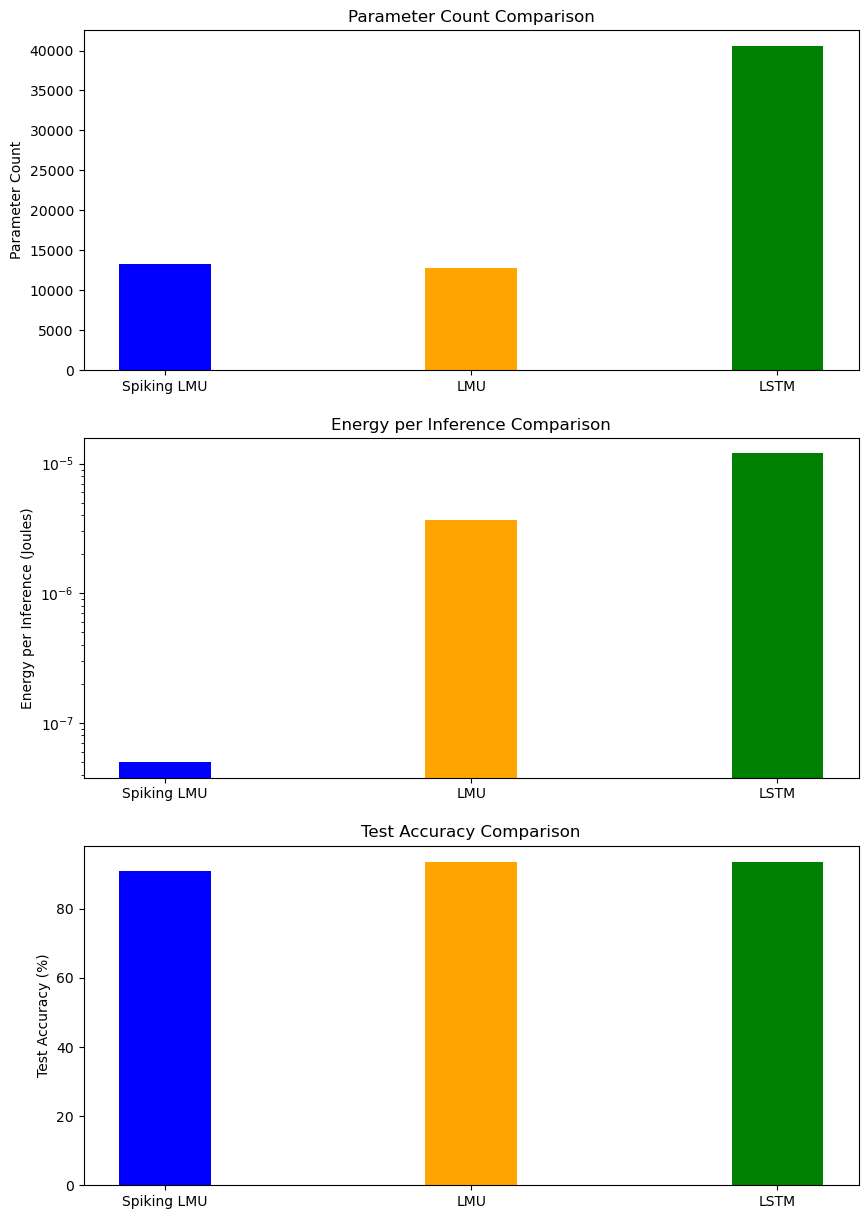

In [25]:
# accuracy vs power consumption 2 y axis bar plot

spiking_lmu_params = 13244
lmu_params = 12785
lstm_params = 40513

spiking_lmu_pow = 4.98e-08
lmu_pow_gpu = 3.65e-06
lSTM_pow_gpu = 1.20e-05

spikin_lmu_acc = test_acc*100
lmu_acc = lmu_eval[1]*100
lstm_acc = lstm_eval[1]*100

# Data
models = ['Spiking LMU', 'LMU', 'LSTM']
param_counts = [13244, 12785, 40513]
energy_per_inference = [4.98e-08, 3.65e-06, 1.20e-05]
test_accuracy = [spikin_lmu_acc, lmu_acc, lstm_acc]

# Bar plots
x = np.arange(len(models))
width = 0.3

fig, ax = plt.subplots(3, 1, figsize=(10, 15))
colors = ['blue', 'orange', 'green']

# Parameter count plot
ax[0].bar(x, param_counts, width, label='Parameter Count', color=colors)
ax[0].set_ylabel('Parameter Count')
ax[0].set_title('Parameter Count Comparison')
ax[0].set_xticks(x)
ax[0].set_xticklabels(models)

# Energy per inference plot
ax[1].bar(x, energy_per_inference, width, label='Energy per Inference', color=colors)
ax[1].set_ylabel('Energy per Inference (Joules)')
ax[1].set_title('Energy per Inference Comparison')
ax[1].set_yscale('log')
ax[1].set_xticks(x)
ax[1].set_xticklabels(models)

# Test accuracy plot
ax[2].bar(x, test_accuracy, width, label='Test Accuracy', color=colors)
ax[2].set_ylabel('Test Accuracy (%)')
ax[2].set_title('Test Accuracy Comparison')
ax[2].set_xticks(x)
ax[2].set_xticklabels(models)

plt.show()

# Feature Importance (Permutation)

In [32]:
feature_names = []
for i in range(4):
    feature_names.append([f'comp{i+1}'+f'_{freqs[j]}'+'hz' for j in range(8, 31)])

feature_names = np.array(feature_names).flatten()

In [41]:
def permute_feature(key='comp1_8.0hz'):
    # return X_test with key feature randomly shuffled
    # key: string, feature name
    # X_test: np.array, shape=(n_samples, n_features, n_channels)
    # return: np.array, shape=(n_samples, n_features, n_channels)
    X_test_perm = X_test.copy()
    idx = np.where(feature_names == key)[0][0]
    # print(idx)
    for i in range(X_test.shape[0]):
        np.random.shuffle(X_test_perm[i, :, idx])
    return X_test_perm

def permutation_importance(model, y_test, acc, key='comp1_8.0hz'):
    # return permutation importance of key feature
    # model: keras model
    # X_test: np.array, shape=(n_samples, n_features, n_channels)
    # y_test: np.array, shape=(n_samples,)
    # key: string, feature name
    # return: float, permutation importance
    X_test_perm = permute_feature(key)
    y_pred_perm = model.predict(X_test_perm)
    acc_perm = accuracy_score(y_test, (y_pred_perm>0.5).astype(int))
    return acc - acc_perm

print(X_test[0, :, 0])
print(permute_feature()[0, :, 0])

[ 0.1113207   1.29291647 -0.23062779  0.43214955  1.10420343  0.02688791
 -0.26010481  0.49862956 -0.10350377]
[ 1.10420343 -0.10350377 -0.23062779  0.02688791  1.29291647 -0.26010481
  0.49862956  0.43214955  0.1113207 ]


In [42]:

importance_dict = {}
for i in feature_names:
    importance_dict[i] = permutation_importance(keras_lmu, y_test, lmu_eval[1], i)

print(importance_dict)

15/15 [==============================] - 0s 20ms/step
{'comp1_8.0hz': -0.0021459058630619587, 'comp1_9.0hz': 0.015021476111186982, 'comp1_10.0hz': 0.015021476111186982, 'comp1_11.0hz': 0.04077254907256034, 'comp1_12.0hz': 0.021459244351530238, 'comp1_13.0hz': 0.012875553364405823, 'comp1_14.0hz': 0.0021459396305002487, 'comp1_15.0hz': 0.004291862377281408, 'comp1_16.0hz': 1.6883719089477722e-08, 'comp1_17.0hz': 0.01931332160474919, 'comp1_18.0hz': 0.01931332160474919, 'comp1_19.0hz': -0.0021459058630619587, 'comp1_20.0hz': 0.023605167098311397, 'comp1_21.0hz': 0.01931332160474919, 'comp1_22.0hz': 0.023605167098311397, 'comp1_23.0hz': 0.03433478083221697, 'comp1_24.0hz': 0.021459244351530238, 'comp1_25.0hz': 0.015021476111186982, 'comp1_26.0hz': 0.03862662632577918, 'comp1_27.0hz': 0.008583707870843615, 'comp1_28.0hz': 0.027897012591873604, 'comp1_29.0hz': 0.021459244351530238, 'comp1_30.0hz': 0.03433478083221697, 'comp2_8.0hz': 0.012875553364405823, 'comp2_9.0hz': 0.015021476111186982,

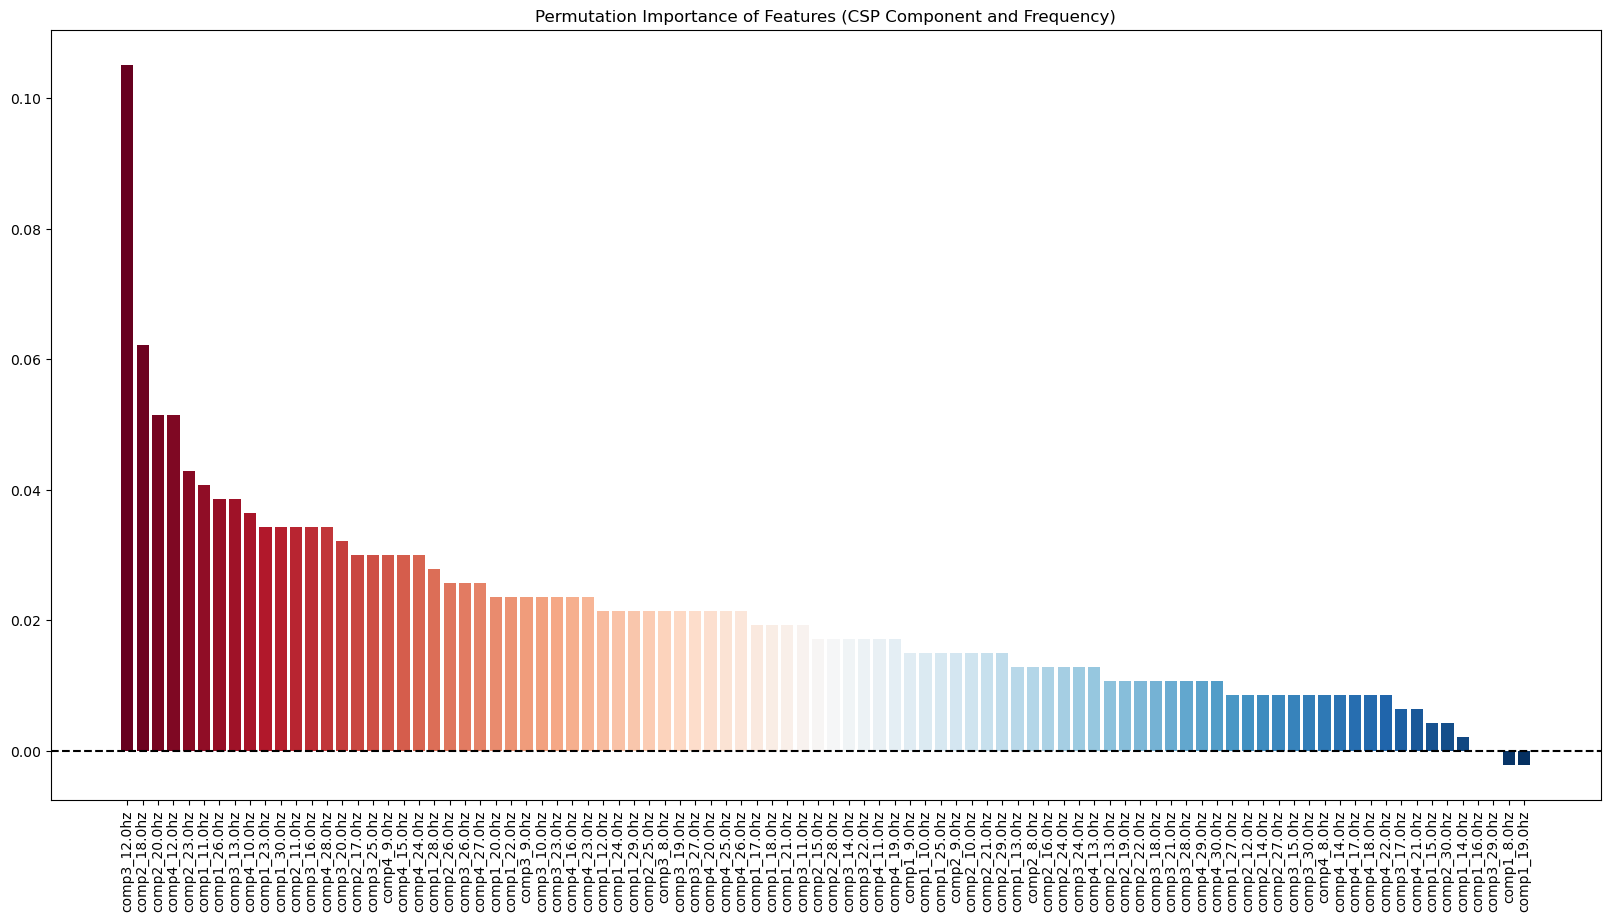

In [69]:
# plot feature importances in descending order and make negative values red
importance_dict = dict(sorted(importance_dict.items(), key=lambda item: item[1], reverse=True))
plt.figure(figsize=(20, 10))
# plt.bar(importance_dict.keys(), importance_dict.values(), color=['red' if v < 0 else 'blue' for v in importance_dict.values()])
plt.bar(importance_dict.keys(), importance_dict.values(), color=plt.cm.RdBu(np.linspace(0, 1, len(importance_dict.values()))))
plt.xticks(rotation=90)
plt.title('Permutation Importance of Features (CSP Component and Frequency)')
plt.axhline(y=0, color='black', linestyle='--')
plt.show()
